In [10]:
import numpy as np
from solvers import *
import matplotlib.pyplot as plt
# import importlib
# importlib.reload(solvers)


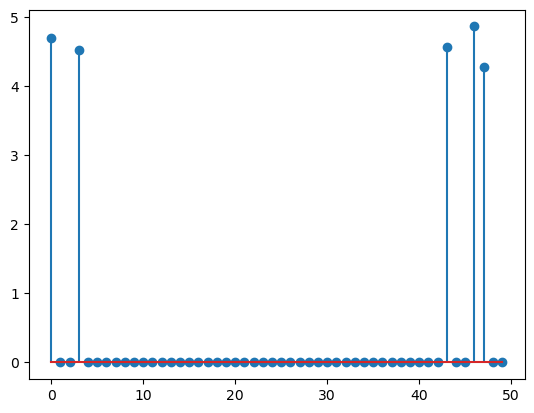

In [11]:
p = 50
m = 40

x0 = np.random.rand(p,)+4
x0[np.random.permutation(p)[:9*p//10] ]=np.zeros(9*p//10,)
A = np.random.randn(m,p)/np.sqrt(m)/4
y = A@x0
lam = np.max(np.abs(A.T@y))*.1

plt.stem(x0)

xinit = 7*np.random.rand(p,)
vinit = 2*np.random.rand(p,)

fval = lambda x: np.linalg.norm(A@x - y)**2 * 0.5
grad = lambda x: A.T@(A@x - y)


In [12]:
from scipy import integrate

if p==1:
    def f(x):
        return np.exp(-fval(np.array([x]))-lam*np.abs(x))
    Total_mass = integrate.quad(f, -np.inf, np.inf)[0]
    print(Total_mass)
    density = lambda x: f(x)/Total_mass
    tgrid = np.linspace(-5,5,1000)
    density_grid = [density(t) for t in tgrid]
    plt.plot(tgrid,density_grid)

if p==2:
    def f(x1,x2):
        return np.exp(-fval(np.array([x1,x2]))-lam*np.abs(x1)-lam*np.abs(x2))
    Total_mass = integrate.dblquad(f, -np.inf, np.inf, -np.inf, np.inf)[0]
    print(Total_mass)
    density = lambda x1,x2: f(x1,x2)/Total_mass
    tgrid = np.linspace(-5,5,1000)
    density_grid = np.array([density(t,s) for t in tgrid for s in tgrid])
    plt.imshow(density_grid.reshape(1000,1000))


In [13]:
def generate_samples_x(Iterate,init, n, burn_in=1000):
    x = init

    #burn in 
    for i in range(burn_in):
        x = Iterate(x)
    p = len(x)

    #record n samples
    samples = np.zeros((n,p))
    for i in range(n):
        x = Iterate(x)
        samples[i,:] = x.reshape(-1)
        
    return samples

        

In [14]:
tau = 1#stepsize
gamma = tau*.001

Iterate = lambda x: prox_langevin(x, grad, tau, gamma, lam)
n = 50000
burn_in = 10000
samples_proxl1 = generate_samples_x(Iterate, xinit, n, burn_in)

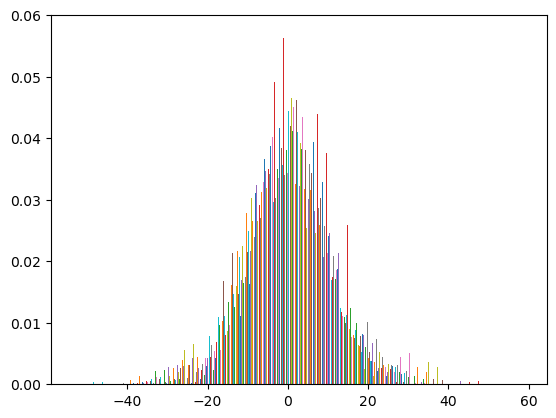

In [15]:
import matplotlib.pyplot as plt
plt.hist(samples_proxl1,100,density=True)

if p==1:
    plt.plot(tgrid,density_grid)
plt.show()

In [29]:
tau = 0.1 #stepsize
print(lam)
Iterate = lambda x: one_step_uv(x, grad, tau, lam)

uvinit = np.concatenate((xinit,vinit))
print(uvinit.shape)

samples_uv = generate_samples_x(Iterate, uvinit, n, burn_in)

0.036205928696823646
(100,)


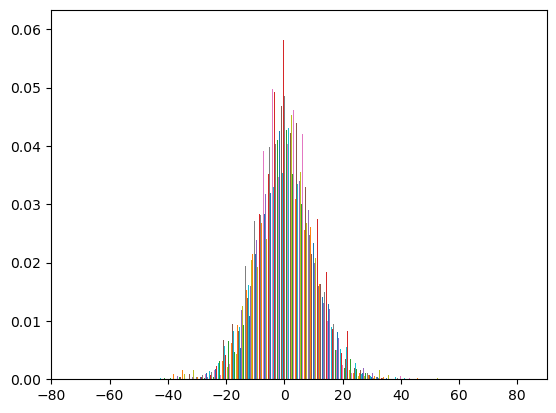

In [30]:
plt.hist(samples_uv[:,:p]*samples_uv[:,p:],100,density=True)
if p==1:
    plt.plot(tgrid,density_grid)
plt.show()

In [32]:
Iterate = lambda x_eta: one_step_gibbs(x_eta, A,y, lam)
x_eta = np.ones(2*p,)
burn_in = 500
n = 1000
gibbs_samples = generate_samples_x(Iterate, x_eta, n, burn_in)

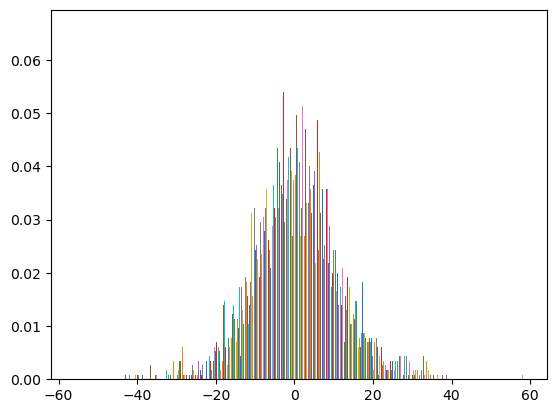

In [33]:
plt.hist(gibbs_samples[:,:p],100,density=True)
if p==1:
    plt.plot(tgrid,density_grid)
plt.show()

In [37]:
#effective sample size
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

algo1 = 'uv_mala'
algo1 = 'uv'
# algo1 = 'gibbs'
algo2 = 'prox_l1'
algo2 = 'gibbs'


def getsamples(method):
    if method == 'gibbs':
        samples = gibbs_samples[:,:p]
    elif method == 'uv':
        samples = samples_uv[:,:p]*samples_uv[:,p:]
    elif method == 'prox_l1':
        samples = samples_proxl1
    return samples

samples1 = getsamples(algo1)
samples2 = getsamples(algo2)


idata_algo1 = az.convert_to_inference_data(np.expand_dims(samples1, 0))
idata_algo2 = az.convert_to_inference_data(np.expand_dims(samples2, 0))


#TODO READ ABOUT ESS AND MAKE COMPARISON HERE

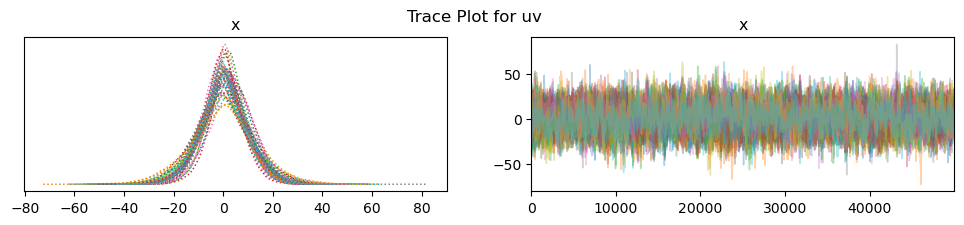

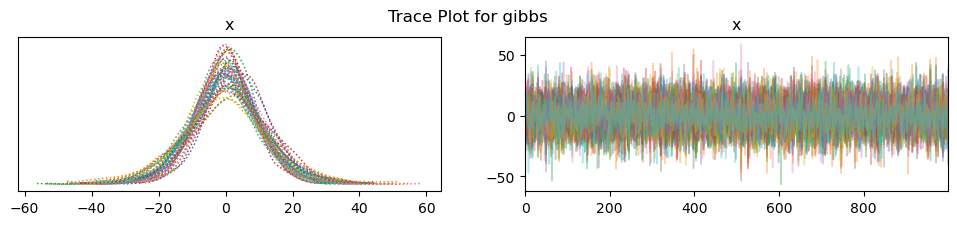

In [38]:
# Plot trace plots for both algorithms using Arviz


trace_plot = az.plot_trace(idata_algo1, var_names=['x'], combined=True )
plt.suptitle('Trace Plot for '+ algo1, y=1.02)

plt.show()

az.plot_trace(idata_algo2, var_names=['x'], combined=True)
plt.suptitle('Trace Plot for ' + algo2, y=1.02)
plt.show()

# plot the running means

(-10.0, 10.0)

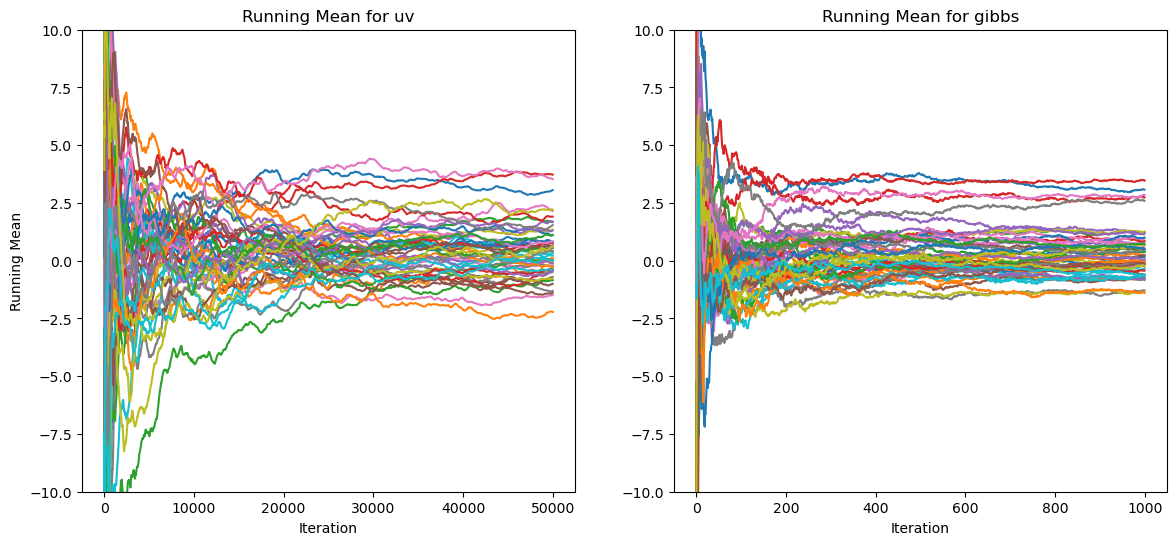

In [39]:

# Calculate running means
running_mean_1 = np.cumsum(samples1, axis=0) / (np.arange(len(samples1))[:, None] + 1)
running_mean_2 = np.cumsum(samples2, axis=0) / (np.arange(len(samples2))[:, None] + 1)

# Plot running means for MALA
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(running_mean_1)
plt.title('Running Mean for ' + algo1)
plt.xlabel('Iteration')
plt.ylabel('Running Mean')
plt.ylim([-10,10])

# Plot running means for ULA
plt.subplot(1, 2, 2)
plt.plot(running_mean_2)
plt.title('Running Mean for ' +algo2)
plt.xlabel('Iteration')
plt.ylim([-10,10])
